In [1]:
import os
import sys

# Data manipulation and visualisation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix


# import python scripts we created to help with feature engineering
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.helpers import identify_missing_data, feature_importance_plot
from src.helpers import identify_highly_correlated_features, one_hot, identify_low_variance_features
from src.learning_curve_plot import learning_curve_plot


### Read and Explore the Data

In [2]:
# read the data

heart_attack_df = pd.read_csv('../data/heart_attack_data.csv')

# preview the data

heart_attack_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [3]:
# check the shape of the data

heart_attack_df.shape

# we have 294 rows of data, and 14 potential features.

(294, 14)

In [4]:
# check the summary information of the data
# do we have any categorical data that needs processing?

heart_attack_df.info()

# there is no categorical data, so we do not need to encode

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [5]:
# identifying missing data

missing_value_df = identify_missing_data(heart_attack_df)

print("# of features with missing data:", missing_value_df[missing_value_df.percent_missing > 0].shape[0])

# of features with missing data: 9


In [6]:
# features that have missing data

missing_value_df[missing_value_df.percent_missing > 0]

,feature,percent_missing,data_type
0,ca,98.98,float64
1,thal,90.48,float64
2,slope,64.63,float64
3,chol,7.82,float64
4,fbs,2.72,float64
5,trestbps,0.34,float64
6,restecg,0.34,float64
7,thalach,0.34,float64
8,exang,0.34,float64


In [7]:
print("# of features with missing data with more than 45% missing data:", missing_value_df[missing_value_df.percent_missing > 45].shape[0])

# of features with missing data with more than 45% missing data: 3


In [8]:
# features that have more than 45% missing data

missing_value_df[missing_value_df.percent_missing > 45]

,feature,percent_missing,data_type
0,ca,98.98,float64
1,thal,90.48,float64
2,slope,64.63,float64


In [9]:
# identifying correlations in data

corr = heart_attack_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# we can see that ca is erroring because it is nearly missing 100% missing data
# negative correlation of -0,45 between thalach and thal, exang and cp have a positive correlation of 0.45
# exang and oldpeak have the highest correlation with the target.

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,0.013618,0.145826,0.245203,0.090979,0.182212,0.051989,-0.459420,0.238925,0.177707,-0.068000,nan,0.274092,0.159315
sex,0.013618,1.000000,0.249875,0.089112,0.028797,0.042798,-0.104614,-0.111781,0.154925,0.118931,0.213921,nan,-0.130013,0.272781
cp,0.145826,0.249875,1.000000,0.085631,0.138847,0.033346,-0.018154,-0.370440,0.494674,0.353109,0.392841,nan,-0.048622,0.505864
trestbps,0.245203,0.089112,0.085631,1.000000,0.084264,0.095416,0.013914,-0.184961,0.213856,0.206848,0.035536,nan,0.206153,0.139717
chol,0.090979,0.028797,0.138847,0.084264,1.000000,0.122902,0.050249,-0.127676,0.168518,0.109343,0.117838,nan,-0.113407,0.209318
fbs,0.182212,0.042798,0.033346,0.095416,0.122902,1.000000,0.049160,-0.071489,0.116170,0.062316,0.201315,nan,0.164353,0.163232
restecg,0.051989,-0.104614,-0.018154,0.013914,0.050249,0.049160,1.000000,0.004481,0.045392,0.042193,-0.031222,nan,-0.188991,-0.029937
thalach,-0.459420,-0.111781,-0.370440,-0.184961,-0.127676,-0.071489,0.004481,1.000000,-0.401980,-0.303028,-0.175356,nan,-0.456133,-0.331393
exang,0.238925,0.154925,0.494674,0.213856,0.168518,0.116170,0.045392,-0.401980,1.000000,0.632108,0.418895,nan,0.181142,0.583847
oldpeak,0.177707,0.118931,0.353109,0.206848,0.109343,0.062316,0.042193,-0.303028,0.632108,1.000000,0.121817,nan,0.116806,0.545700


In [10]:
# can also use the definition to identify patterns to look for correlations between features
identify_highly_correlated_features(heart_attack_df, correlation_threshold=0.3)

# i missed the relationship between exange and oldpeak when looking at the plot

,corr_feature,drop_feature,corrrelation_values
10,exang,oldpeak,0.63
12,exang,target,0.58
13,oldpeak,target,0.55
14,slope,target,0.54
15,thal,target,0.53
5,cp,target,0.51
2,cp,exang,0.49
0,age,thalach,0.46
8,thalach,thal,0.46
11,exang,slope,0.42


In [11]:
# identifying features with low variance

heart_attack_df.std()

# ca has no low variance, which we know since everything is missing. Can not see any features with low variance.

age          7.811812
sex          0.447533
cp           0.965117
trestbps    17.626568
chol        67.657711
fbs          0.255476
restecg      0.460868
thalach     23.589749
exang        0.460665
oldpeak      0.908648
slope        0.338995
ca           0.000000
thal         1.615074
target       0.480977
dtype: float64

In [12]:
# identify features with low variance

identify_low_variance_features(heart_attack_df, std_threshold=0.1)

number of low variance features: 1
low variance features: ['ca']


['ca']

In [13]:
# check the distribution of the target

heart_attack_df.target.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with only 36% of patients with known heartattacks
# Since the target is 1 and 0, we need to use classification algorithms to make predictions.

0    0.639456
1    0.360544
Name: target, dtype: float64

In [14]:
heart_attack_df.target.value_counts(normalize = True)

0    0.639456
1    0.360544
Name: target, dtype: float64

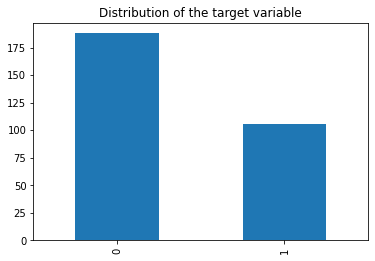

In [15]:
# visualise the distribution of the target

heart_attack_df.target.value_counts(dropna = True).plot(kind = 'bar')
plt.title("Distribution of the target variable");

# question: does the distribution look equal to you? 
# example of an imbalanced dataset

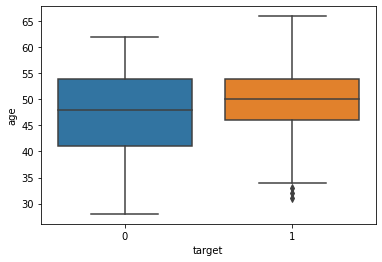

In [16]:
# I am interested in looking at patterns between age and the target.
# My assumption is that older people have had more heart attacks, even though this has a low correlation.

sns.boxplot(x=heart_attack_df.target, y=heart_attack_df.age);

# The boxplots show that patients with heart attacks have a higher age range, than patients that have not.
# Younger patients are considered outliers amongst patients with heart attacks. That's interesting!

## Cleaning the Data

In [17]:
# identify duplicates in data

heart_attack_df[heart_attack_df.duplicated(keep=False)]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
101,49,0,2,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
102,49,0,2,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0


In [18]:
print(heart_attack_df.shape)

heart_attack_df_cleaned = heart_attack_df[~heart_attack_df.duplicated(keep='first')]

print(heart_attack_df_cleaned.shape)

(294, 14)
(293, 14)


## Feature Engineering

In [19]:
# drop features which have more than 45% missing values

threshold = 45

missing_value_df = identify_missing_data(heart_attack_df_cleaned)
missing_value_df

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 3
['ca', 'thal', 'slope']


In [20]:
# drop the features

heart_attack_df_cleaned.drop(cols_to_drop, axis = 1, inplace = True)

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
# check the columns were dropped

missing_value_df = identify_missing_data(heart_attack_df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,chol,7.51,float64
1,fbs,2.73,float64
2,trestbps,0.34,float64
3,restecg,0.34,float64
4,thalach,0.34,float64
5,exang,0.34,float64
6,age,0.00,int64
7,sex,0.00,int64
8,cp,0.00,int64
9,oldpeak,0.00,float64


In [22]:
# fill the remaining features with missing values with 0

heart_attack_df_cleaned.chol.fillna(0, inplace = True)
heart_attack_df_cleaned.fbs.fillna(0, inplace = True)
heart_attack_df_cleaned.trestbps.fillna(0, inplace = True)
heart_attack_df_cleaned.restecg.fillna(0, inplace = True)
heart_attack_df_cleaned.exang.fillna(0, inplace = True)
heart_attack_df_cleaned.thalach.fillna(0, inplace = True)


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [23]:
missing_value_df = identify_missing_data(heart_attack_df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,age,0.0,int64
1,sex,0.0,int64
2,cp,0.0,int64
3,trestbps,0.0,float64
4,chol,0.0,float64
5,fbs,0.0,float64
6,restecg,0.0,float64
7,thalach,0.0,float64
8,exang,0.0,float64
9,oldpeak,0.0,float64


In [24]:
# Since we have no categorical data we do not have to do any encoding

In [25]:
# Since we have no highly correlated features, we do not need to drop any features

In [26]:
# Since we have no additional features with low variance (we already dropped ca), we do not need to drop any features

In [27]:
heart_attack_df_cleaned.shape

(293, 11)

### Split the data into train and test

In [27]:
# define the target and features

target = heart_attack_df_cleaned["target"]
features = heart_attack_df_cleaned.drop(["target"], axis = 1)


In [28]:
target.shape

(293,)

In [29]:
features.shape

(293, 10)

In [30]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                stratify = target,
                                                test_size = 0.2, 
                                                random_state = 8888)



In [31]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Distribution of target:", Counter(y_train))

Training Data
Shape of X_train (234, 10)
Shape of y_train (234,)
Distribution of target: Counter({0: 149, 1: 85})


In [32]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Distribution of target:", Counter(y_test))

Test Data
Shape of X_test (59, 10)
Shape of y_test (59,)
Distribution of target: Counter({0: 38, 1: 21})


In [81]:
# scale the data

scaler = StandardScaler()
scaler.fit(X_train)
# transform training data
X_train_scaled = scaler.transform(X_train)


### Build and Evaluate the Decision Tree Model 

In [82]:
# Import and Fit the Decision Tree Model

clf = LogisticRegression()

clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [83]:
# Make predictions on unseen data

y_pred_clf = clf.predict(X_test) 
y_pred_clf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [84]:
print("first five predicted values:", y_pred_clf[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [1 1 1 1 1]
first five actual values: [1, 0, 1, 1, 0]


In [85]:
# accuracy
# Very simply, accuracy is the fraction of predictions our model got right. 

accuracy_score(y_test, y_pred_clf)


0.3898305084745763

In [86]:
# recall
# What proportion of actual positives (1) was identified correctly?
# tp / tp + fn

recall_score(y_test, y_pred_clf)


0.9523809523809523

In [87]:
# precision
# What proportion of positive identifications (1) was actually correct?
# tp / tp + fp

precision_score(y_test, y_pred_clf)

0.36363636363636365

In [88]:
# f1 score
# balance between precision and recall

f1_score(y_test, y_pred_clf)

0.5263157894736843

In [89]:
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

confusion_matrix(y_test, y_pred_clf)

array([[ 3, 35],
       [ 1, 20]])

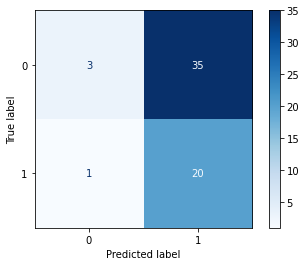

In [90]:
# can easily see where the model has incorrectly classified the data

plot_confusion_matrix(clf, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

In [91]:
print(classification_report(y_test, y_pred_clf))

# the model is better at predicting patients without heart attacks - f1-score of 0.78 vs f1-score of 0.59

              precision    recall  f1-score   support

           0       0.75      0.08      0.14        38
           1       0.36      0.95      0.53        21

    accuracy                           0.39        59
   macro avg       0.56      0.52      0.33        59
weighted avg       0.61      0.39      0.28        59



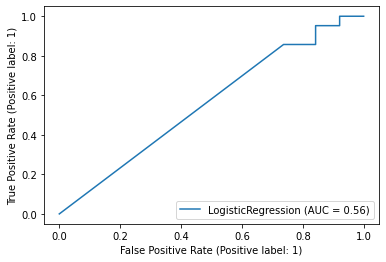

In [92]:
from sklearn.metrics import plot_roc_curve

# handy sklearn function to plot Receiver operating characteristic (ROC) curve, with the area under the curve.
# The TPR (recall) defines how many correct positive results occur among all positive samples available during the test. 
# FPR, on the other hand, defines how many incorrect positive results occur among all negative samples 
# available during the test.

plot_roc_curve(clf,
               X_test, 
               y_test);                      

# AUC of 0.63; the higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

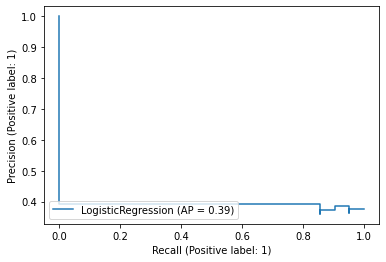

In [93]:
from sklearn.metrics import plot_precision_recall_curve

# Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
# In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
# The precision-recall curve shows the tradeoff between precision and recall for different threshold. 

plot_precision_recall_curve(clf,
                            X_test,
                            y_test);

# Balance between precision and recall could be higher

In [94]:
# check for signs of overfitting

y_pred_train_clf = clf.predict(X_train)

print("accuracy:", round(accuracy_score(y_train, y_pred_train_clf), 2))
print("recall:", round(recall_score(y_train, y_pred_train_clf), 2))
print("precision:", round(precision_score(y_train, y_pred_train_clf), 2))
print("f1-score:", round(f1_score(y_train, y_pred_train_clf), 2))

# high accuracy on training set, signs of variance between test and training set.

accuracy: 0.41
recall: 0.96
precision: 0.38
f1-score: 0.54


In [96]:
# on test set - seeing simialr results

print("accuracy:", round(accuracy_score(y_test, y_pred_clf), 2))
print("recall:", round(recall_score(y_test, y_pred_clf), 2))
print("precision:", round(precision_score(y_test, y_pred_clf), 2))
print("f1-score:", round(f1_score(y_test, y_pred_clf), 2))


accuracy: 0.39
recall: 0.95
precision: 0.36
f1-score: 0.53


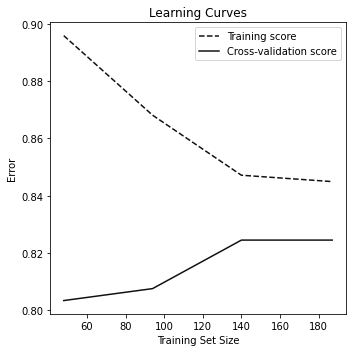

In [95]:
learning_curve_plot(clf, X_train, y_train, scoring = 'accuracy')

# gap between curves showing some of overfitting, but this could be improved with more data/feature engineering/different models


### Build and Evaluate the Random Forest

In [48]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [49]:
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0])

In [50]:
print("first five predicted values:", y_pred_rf[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [1 0 1 1 0]
first five actual values: [1, 0, 1, 1, 0]


In [51]:
print("accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))
print("recall:", round(recall_score(y_test, y_pred_rf), 2))
print("precision:", round(precision_score(y_test, y_pred_rf), 2))
print("f1-score:", round(f1_score(y_test, y_pred_rf), 2))


# do we see an improvement in accuracy?

accuracy: 0.8
recall: 0.62
precision: 0.76
f1-score: 0.68


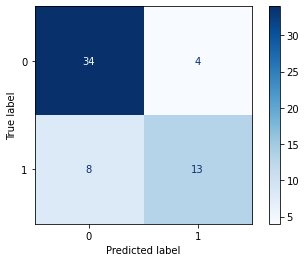

In [52]:
# plot confusion matrix

plot_confusion_matrix(rf, X_test, y_test, cmap = plt.cm.Blues);

In [53]:
# print classification report

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        38
           1       0.76      0.62      0.68        21

    accuracy                           0.80        59
   macro avg       0.79      0.76      0.77        59
weighted avg       0.79      0.80      0.79        59



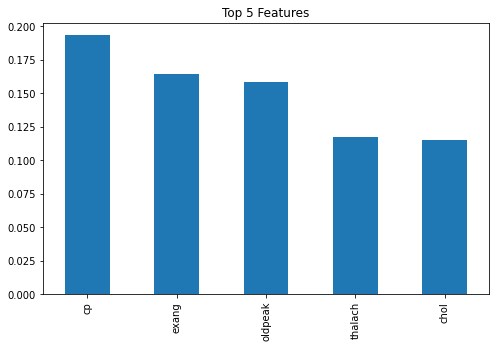

In [54]:
# feature importance plot

feature_importance_plot(rf, X_train, n = 5) 


In [55]:
# performance on training data

y_pred_train_rf =rf.predict(X_train)

print("accuracy:", round(accuracy_score(y_train, y_pred_train_rf), 2))
print("recall:", round(recall_score(y_train, y_pred_train_rf), 2))
print("precision:", round(precision_score(y_train, y_pred_train_rf), 2))
print("f1-score:", round(f1_score(y_train, y_pred_train_rf), 2))



accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


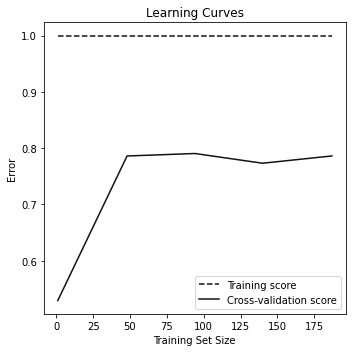

In [56]:
learning_curve_plot(rf, X_train, y_train, scoring = 'accuracy')

# signs of overfitting, but slightly less than decision tree

### Build and Evaluate the XGBoost Model 

In [57]:
# fit the XGBoost model to training data

xgb = XGBClassifier()
xgb.fit(X_train, y_train)


[22:21:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
# make predictions on the test set

y_pred_xgb = xgb.predict(X_test)

print("first five predicted values:", y_pred_xgb[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [1 0 1 1 0]
first five actual values: [1, 0, 1, 1, 0]


In [59]:
# evaluation metrics comparing predictions and actual values

print("accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("recall:", round(recall_score(y_test, y_pred_xgb), 2))
print("precision:", round(precision_score(y_test, y_pred_xgb), 2))
print("f1-score:", round(f1_score(y_test, y_pred_xgb), 2))

# Random Forest has a higher recall than the XGBoost model

accuracy: 0.76
recall: 0.62
precision: 0.68
f1-score: 0.65


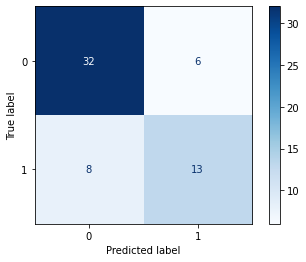

In [60]:
# confusion matrix

plot_confusion_matrix(xgb, X_test, y_test, cmap = plt.cm.Blues);


In [61]:
# classification report

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.81      0.89      0.85        38
           1       0.76      0.62      0.68        21

    accuracy                           0.80        59
   macro avg       0.79      0.76      0.77        59
weighted avg       0.79      0.80      0.79        59



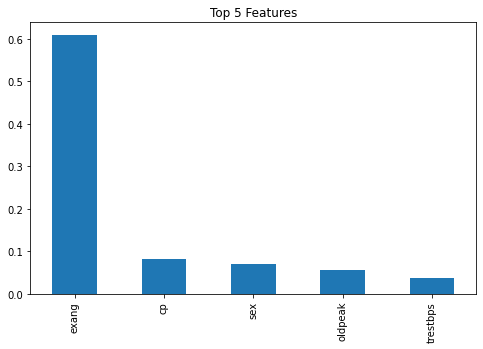

In [62]:
# feature importance plot, exang appears to be the most important feature
# with random forest model the features have higher scores

feature_importance_plot(xgb, X_train, n = 5) 


In [63]:
y_pred_train_xgb =xgb.predict(X_train)

print("accuracy:", round(accuracy_score(y_train, y_pred_train_xgb), 2))
print("recall:", round(recall_score(y_train, y_pred_train_xgb), 2))
print("precision:", round(precision_score(y_train, y_pred_train_xgb), 2))
print("f1-score:", round(f1_score(y_train, y_pred_train_xgb), 2))

# signs of overfitting

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


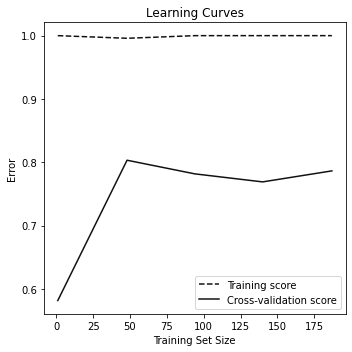

In [64]:
learning_curve_plot(xgb, X_train, y_train, scoring = 'accuracy')

Model Selection
- Best model is ??
- XGBoost and Random Forest might be too complex for this dataset